In [24]:
import h5py
import numpy as np
import glob2
import os
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import json
import pandas as pd

In [2]:
# All params
Q_list = [0.15]
W_list = [0.15]
D_list = [0.6]
T_list = [0.00001, 0.0001, 0.001, 0.01, 0.025, 0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1.0]
decay_list = [18.0]

seed_list = list(np.arange(0, 25))

### Plot AUCs

In [3]:
# Build matrix

n_experiments = len(T_list)
n_timesteps = 8000
n_trials = 25

def build_matrix(distance_data, n_experiments, n_trials, n_timesteps):
    total_matrix = np.zeros((n_experiments, n_trials, n_timesteps))
    seeds_list = []
    param_list = []

    for data_i, (data_key, data_val) in enumerate(distance_data.items()):
        single_set = []

        for trial_i, (trial_key, trial_vals) in enumerate(data_val.items()):
            single_set.append(trial_vals)

            for val in trial_vals:
                seeds_list.append(trial_key)
                param_list.append(data_key)

        single_set = np.array(single_set)
        total_matrix[data_i] = single_set

    return total_matrix, seeds_list, param_list


In [14]:
# Create dataframes and concat

def create_df(total_matrix, seeds_list, param_list, T_list, bias):
    step_size = 50

    total_matrix = total_matrix[:,:,::step_size]
    seeds_list = np.array(seeds_list[::step_size])
    param_list = np.array(param_list[::step_size])
    n_timesteps = total_matrix.shape[2]
    
    # Distance data
    distance_np = total_matrix.flatten()
    distance_df = pd.DataFrame(data=distance_np, columns=['Distance'])
    
    # Time data
    timesteps_np = np.tile(list(range(n_timesteps)), n_trials*n_experiments)
    timesteps_df = pd.DataFrame(data=timesteps_np, columns=["Time"])

    # Param data: T and bias
    T_params_list = np.array(T_list).repeat(25)
    params_df = pd.DataFrame(data=T_params_list, columns=['Threshold'])
    
    if bias:
        bias_on_np = np.ones(T_params_list.shape[0]) * 5
        bias_df = pd.DataFrame(data=bias_on_np, columns=['Bias'])
    else:
        bias_on_np = np.zeros(T_params_list.shape[0])
        bias_df = pd.DataFrame(data=bias_on_np, columns=['Bias'])

    # Total distance df: Distance, Time, Threshold
    df_distance = pd.concat((distance_df, timesteps_df, params_df, bias_df), axis=1)
    
    # Total AUC df: AUC, Threshold, Bias
    AUCs = total_matrix.sum(axis=2)
    AUCs_np = AUCs.flatten()
    AUCs_df = pd.DataFrame(data=AUCs_np, columns=['AUCs'])
    df_auc = pd.concat((AUCs_df, params_df, bias_df), axis=1)

    return df_distance, df_auc

In [15]:
def concat_df_by_bias(distance_data_wb0, distance_data_wb5, n_experiments, n_trials, n_timesteps):

    total_matrix, seeds_list, param_list = build_matrix(distance_data_wb0, n_experiments, n_trials, n_timesteps)
    df_distance, df_auc = create_df(total_matrix, seeds_list, param_list, T_list, bias=0)

    total_matrix2, seeds_list2, param_list2 = build_matrix(distance_data_wb5, n_experiments, n_trials, n_timesteps)
    df_distance2, df_auc2 = create_df(total_matrix2, seeds_list2, param_list2, T_list, bias=1)
    
    distance_concat = pd.concat((df_distance, df_distance2), axis=0)
    auc_concat = pd.concat((df_auc, df_auc2), axis=0)
    
    return distance_concat, auc_concat


In [16]:
def plot_bar(df_concat, density, order):
    sns.set(font_scale=1.2)
    palette = sns.color_palette("Set2", 12)

    sns.barplot(x='Threshold', y='AUCs', hue="Bias", data=df_concat, 
                estimator=np.mean, palette=palette, ax=order)
    sns.despine()


In [17]:
sns.set(style="ticks")

Text(0.5,0.94,'Area under curves of distance to queen')

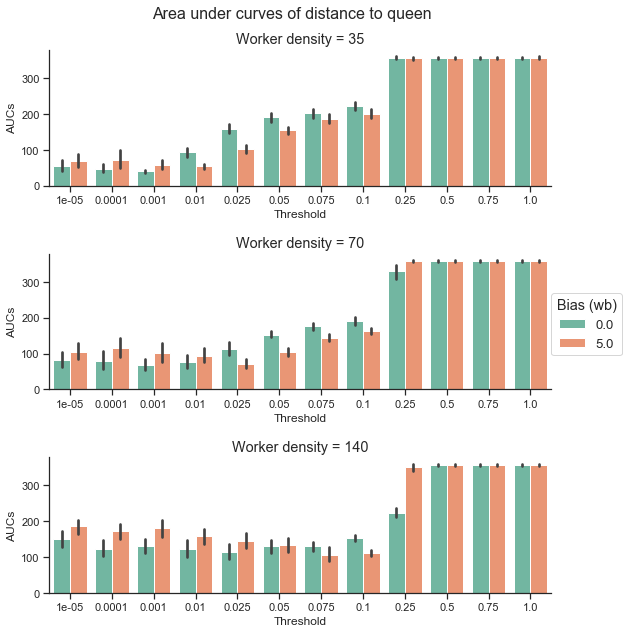

In [18]:
densities = [35, 70, 140]

fig, axs = plt.subplots(3, 1, figsize=(9, 10), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace=0.5, wspace=0.2)
axs = axs.ravel()

for ax, (d_i, d) in zip(axs, enumerate(densities)):
    filename = f"distance_data/wb=0/distance_data_n={d}.json"
    filename2 = f"distance_data/wb=5/distance_data_n={d}.json"

    with open(filename) as f:
        distance_data_wb0 = json.load(f)

    with open(filename2) as f:
        distance_data_wb5 = json.load(f)

    distance_concat, auc_concat = concat_df_by_bias(distance_data_wb0, distance_data_wb5, n_experiments, n_trials, n_timesteps)
    plot_bar(auc_concat, d, axs[d_i])
    ax.set_title(f"Worker density = {d}")
    ax.legend_.remove()

leg = plt.legend(loc=(1, 1.75), title='Bias (wb)') 
frame = leg.get_frame()
frame.set_facecolor('white')

plt.suptitle('Area under curves of distance to queen', size=16, x=0.5, y=0.94)
